In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import yfinance as yf
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from pylab import rcParams
from sklearn.metrics import mean_absolute_error

plt.style.use(style='seaborn')
%matplotlib inline

In [2]:
tesla = yf.download("TSLA", start = "2012-05-01", end = "2022-05-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.plot(x, y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

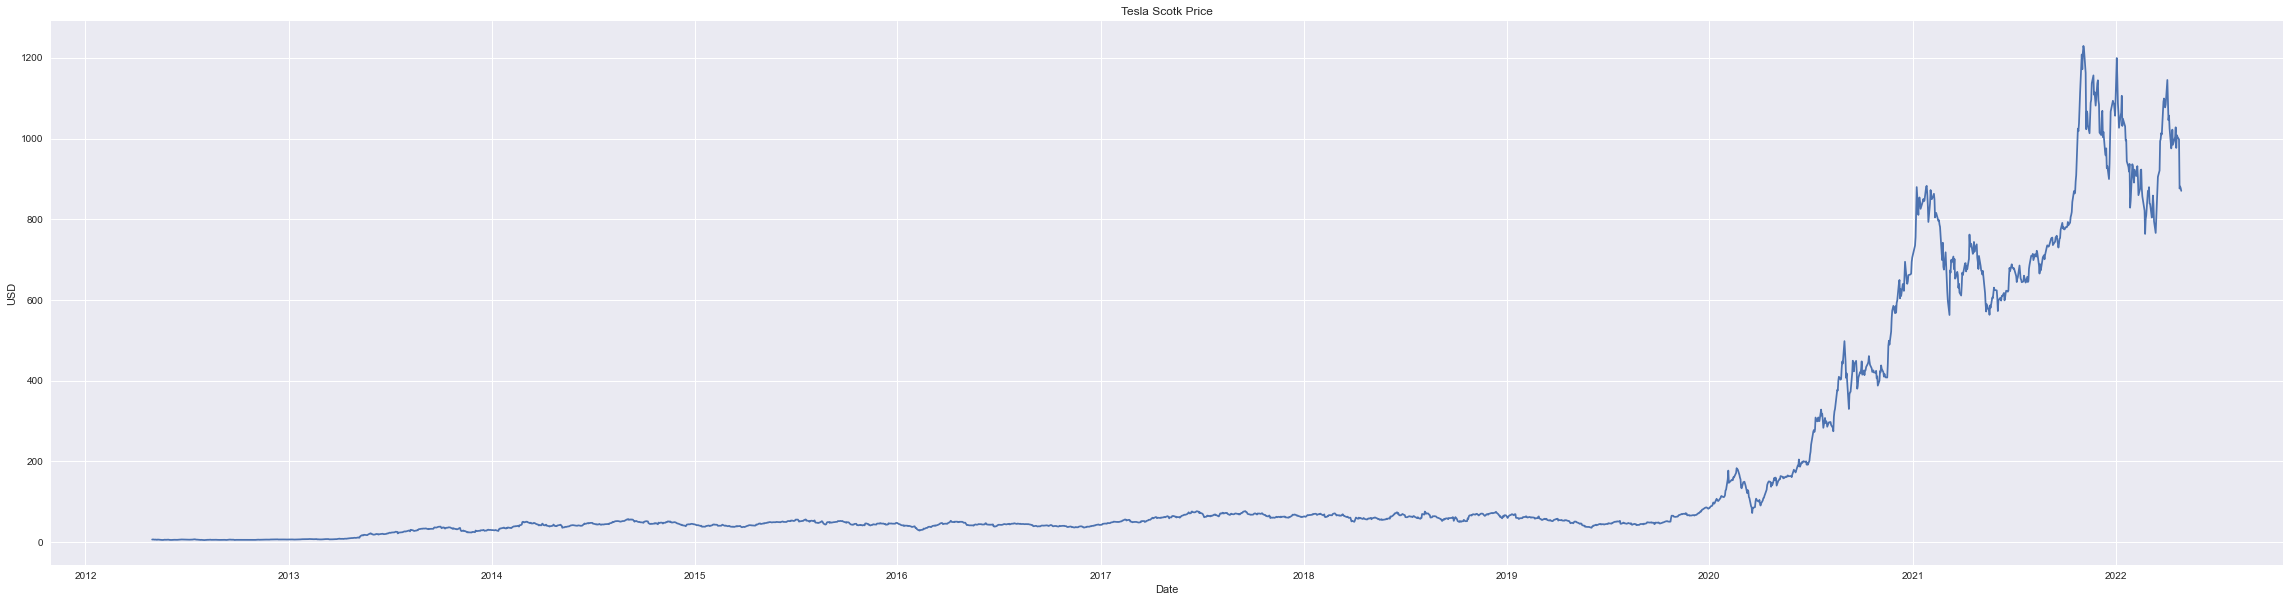

In [4]:
rcParams['figure.figsize'] = 40, 10
plot_df(tesla, tesla.index , tesla['Close'], title='Tesla Scotk Price',ylabel='USD')

In [5]:
adf_test = adfuller(tesla['Close'])
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : 0.49025295401553276
P Value : 0.984573812363296



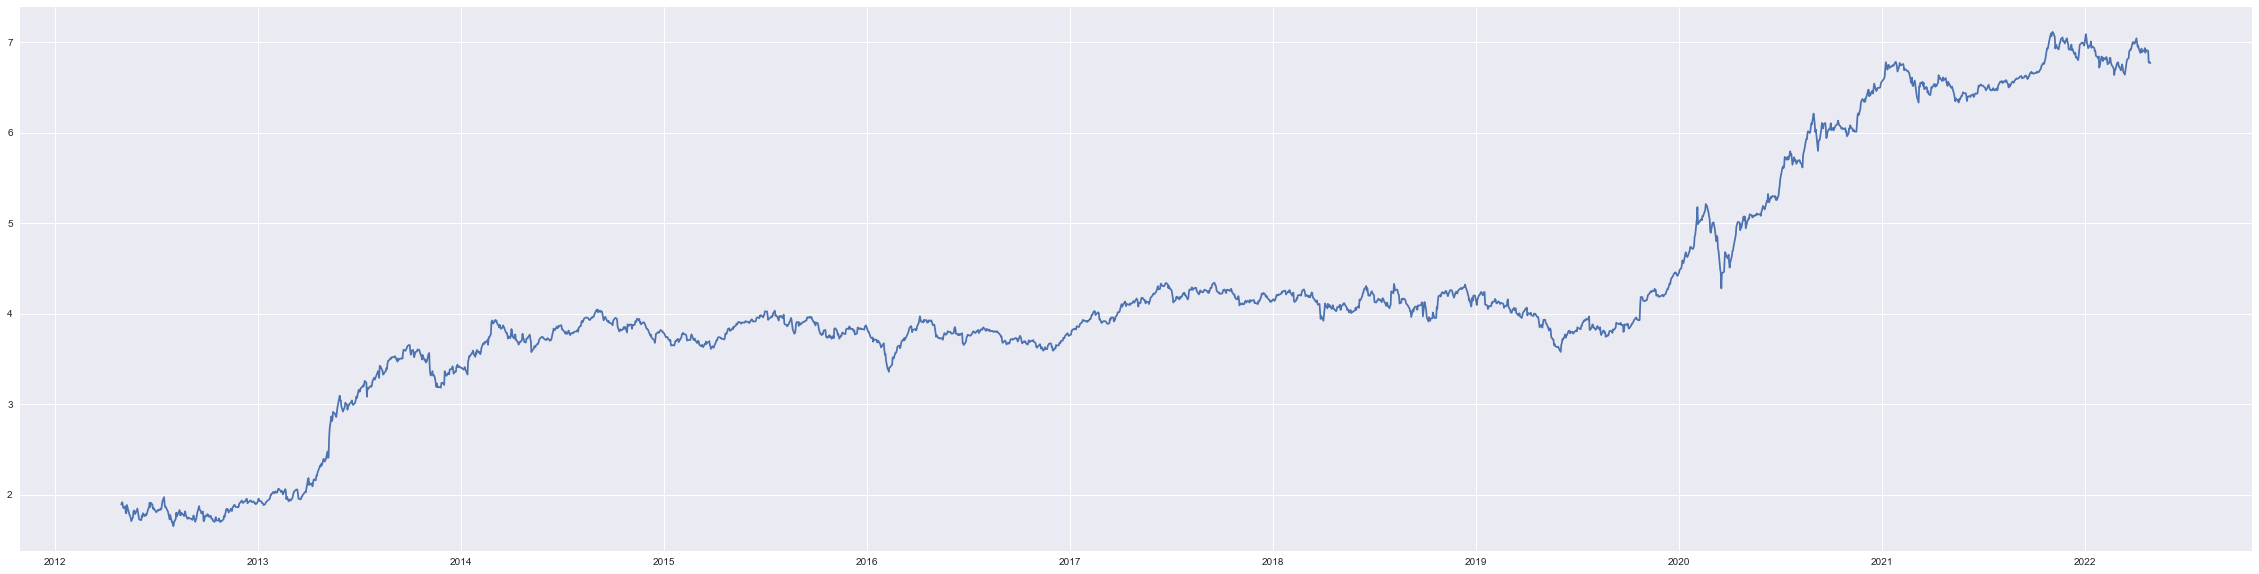

In [6]:
plt.plot(tesla.apply(np.log)['Close'])

In [7]:
adf_test = adfuller(np.log(tesla['Close']))
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : -0.41521167793078906
P Value : 0.9075278232891206



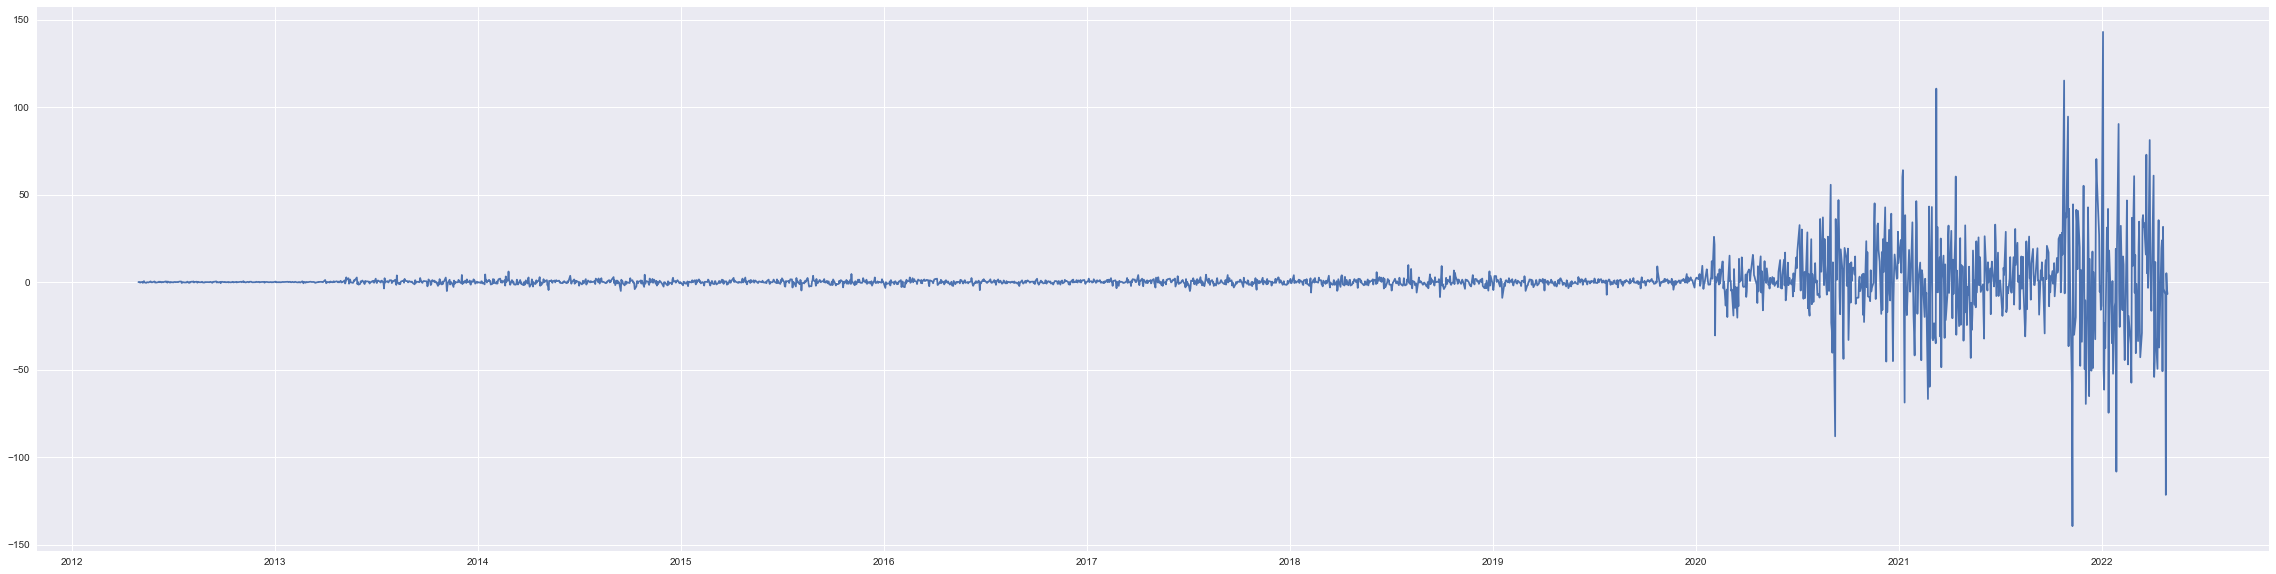

In [8]:
plt.plot(tesla['Close'].diff(1).fillna(0))

In [9]:
adf_test = adfuller(np.log(tesla['Close']).diff(1).fillna(0))
adf_test = adfuller((tesla['Close']).diff(1).fillna(0))
print(f"""
ADF Value : {adf_test[0]}
P Value : {adf_test[1]}
""")


ADF Value : -10.575184433416304
P Value : 7.1358348297962875e-19



In [10]:
tesla_st = tesla.diff(1).fillna(0)
tesla_st.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-04-30,0.000,0.000,0.000,0.000,0.000,0.0
2012-05-01,-0.028,0.170,0.110,0.130,0.130,1225500.0
2012-05-02,0.074,0.036,0.052,0.032,0.032,-808500.0
2012-05-03,0.082,-0.078,-0.252,-0.296,-0.296,1720000.0
2012-05-04,-0.318,-0.308,-0.146,-0.126,-0.126,2031000.0


In [11]:
class TimeSeriesData():
    def __init__(self, df):
        self.data = df 
        self.stationary = self.stationarize(df)
        self.reconstructed = self.reconstruct(self.stationary, self.data)
        
    def reconstruct(self, st, org):
        x = st.copy()
        x.iloc[0,:] = org.iloc[0,:]
        return x.cumsum()
    
    def stationarize(self, data):
        return data.diff(1).fillna(0)

In [12]:
x_train = TimeSeriesData(tesla[:int((len(tesla)*0.9))])
x_valid = TimeSeriesData(tesla[int((len(tesla)*0.9)):])
x_train.data.shape[0] + x_valid.data.shape[0] == tesla.shape[0]

True

In [13]:
x_valid.data.shape

(252, 6)

In [14]:
x_train.data.shape

(2266, 6)

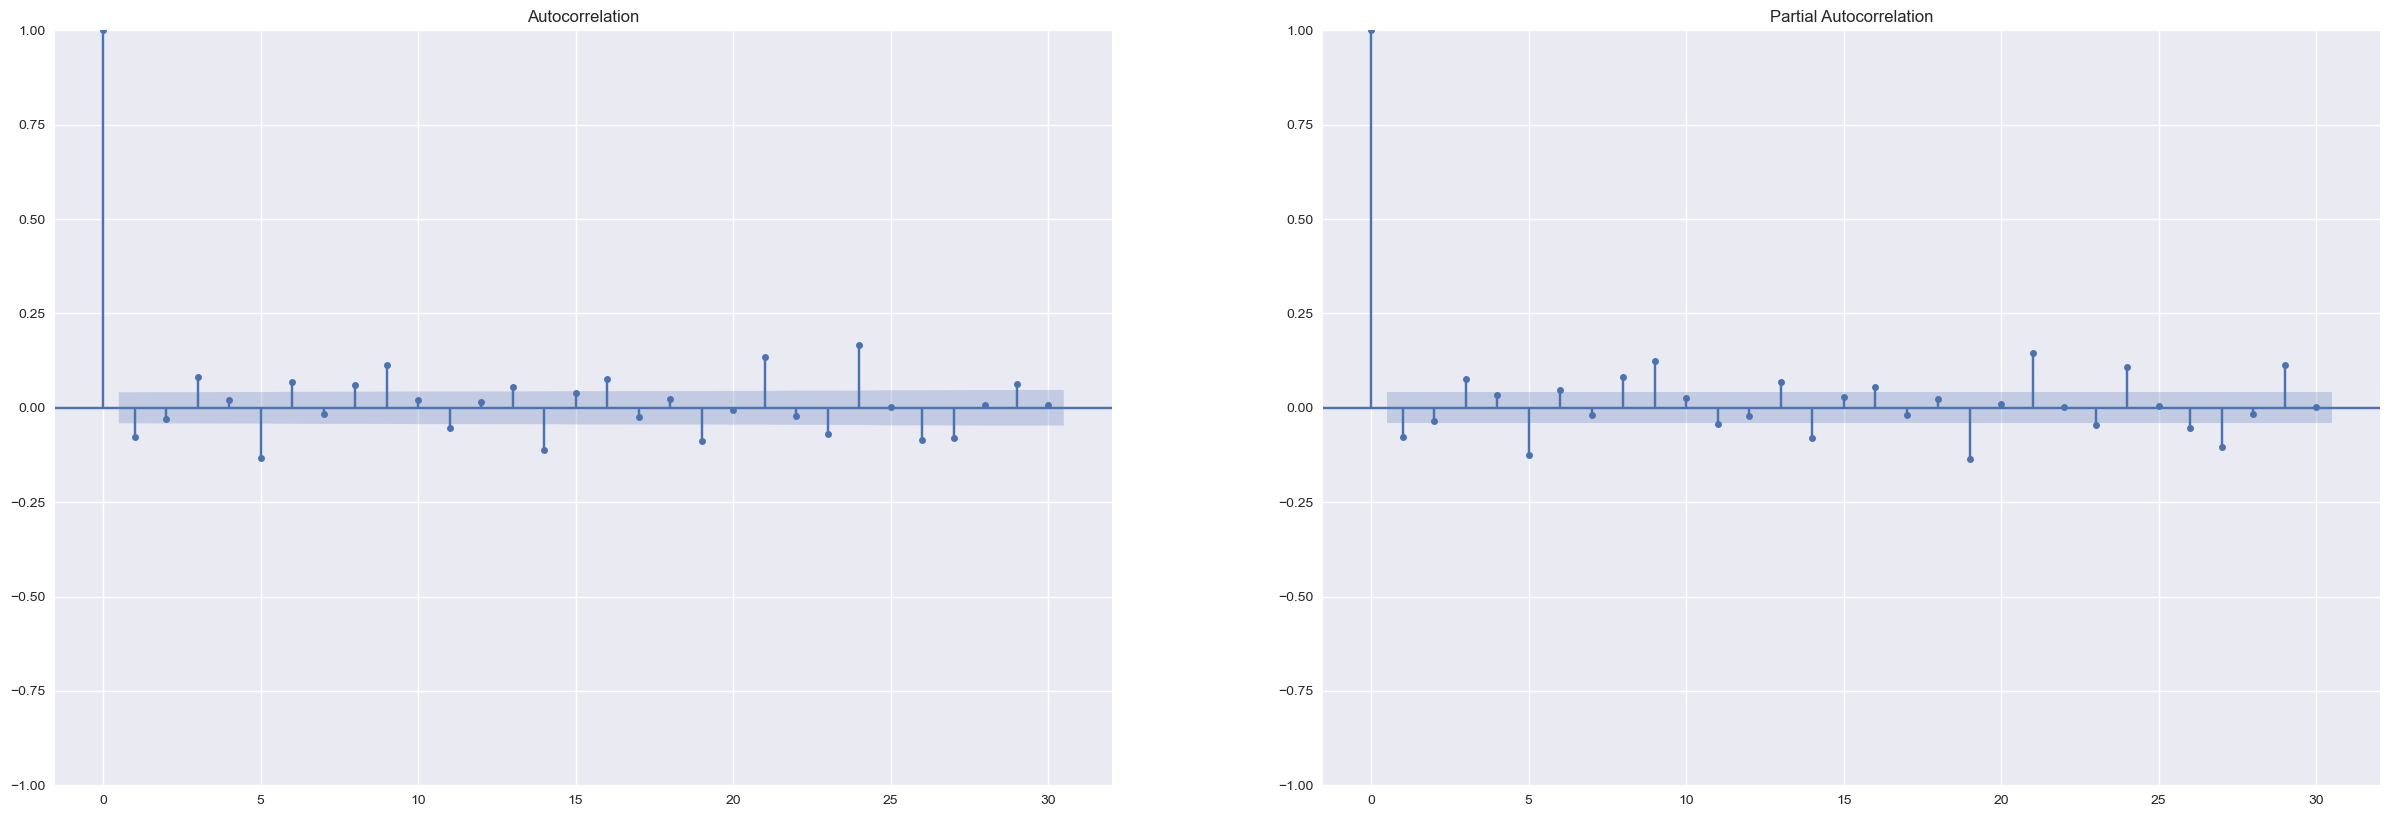

In [15]:
fig, axes = plt.subplots(1,2,figsize=(30,10), dpi= 100)
plot_acf(x_train.stationary['Close'].values.tolist(), lags=30, ax=axes[0]);
plot_pacf(x_train.stationary['Close'].values.tolist(), lags=30, ax=axes[1]);

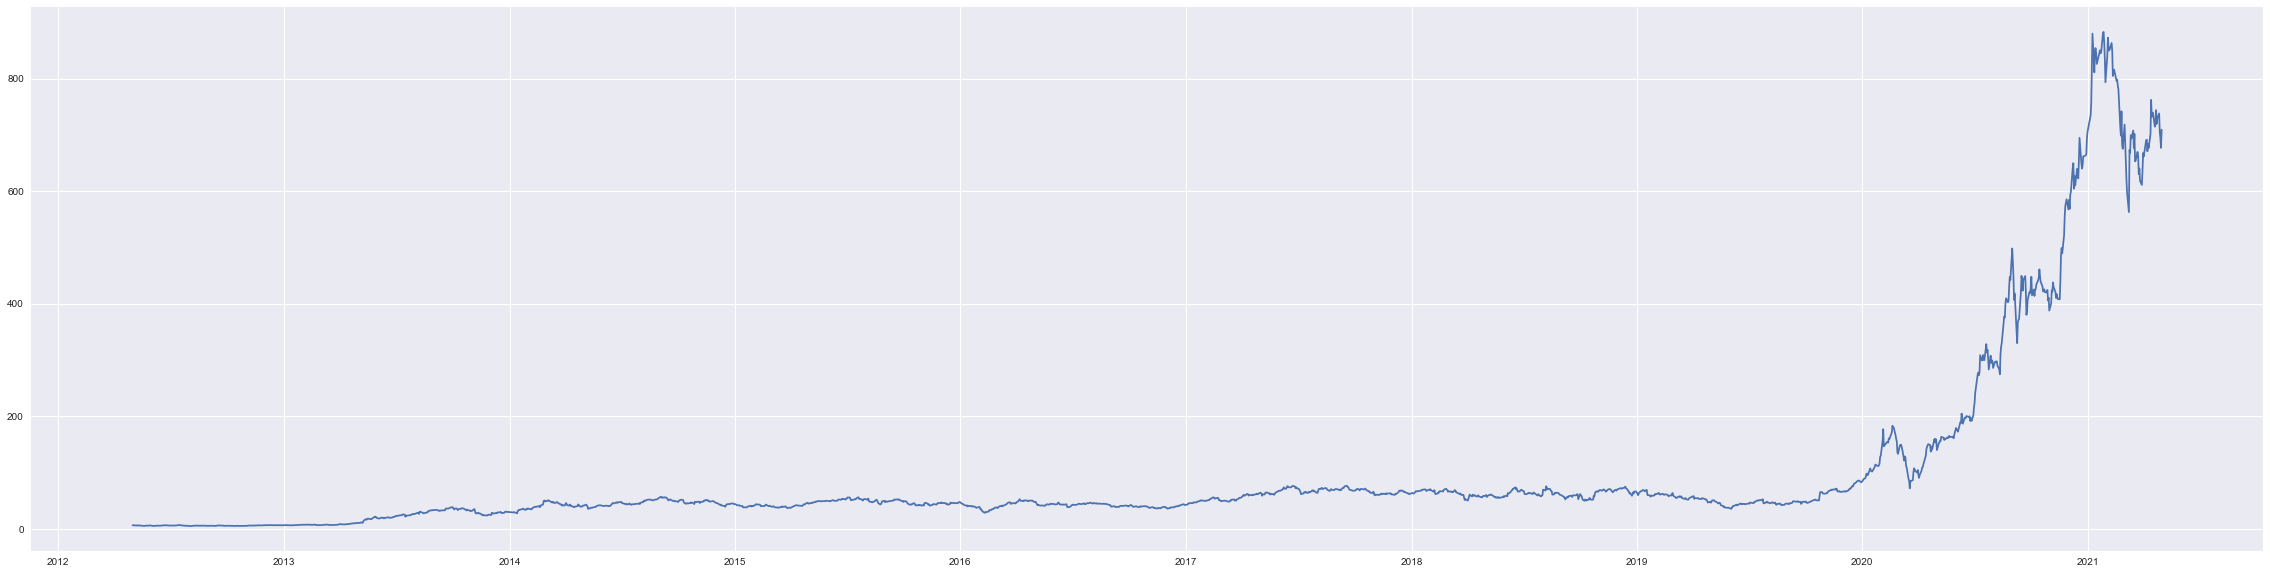

In [16]:
plt.plot(x_train.data['Close'])

In [17]:
model_arima = ARIMA(x_train.data['Close'].values, order=(0,1,0))

In [18]:
result_arima = model_arima.fit()

In [19]:
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2266
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -7925.305
Date:                Sat, 07 May 2022   AIC                          15852.611
Time:                        01:56:07   BIC                          15858.336
Sample:                             0   HQIC                         15854.700
                               - 2266                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        64.0841      0.406    157.847      0.000      63.288      64.880
Ljung-Box (L1) (Q):                  13.18   Jarque-Bera (JB):            166735.49
Prob(Q):                              0.00   Pr

In [20]:
p = q = range(0, 6)
d = 1
pdq = list(itertools.product(p, [d], q))

In [21]:
results = []
models = []
for param in pdq:
    _model = ARIMA(x_train.data['Close'].values, order=param)
    try:
        results.append(_model.fit().aic)
        models.append('ARIMA (' + ' '.join(list(map(str, param)))+')')
    except:
        pass

In [22]:
all_model = pd.DataFrame(list(zip(models, results)), columns=['model', 'AIC'])
all_model.sort_values(by='AIC').reset_index(drop=True)

,model,AIC
0,ARIMA (5 1 4),15732.194124
1,ARIMA (5 1 5),15733.864721
2,ARIMA (4 1 5),15735.685310
3,ARIMA (3 1 2),15741.929749
4,ARIMA (3 1 3),15745.416404
...,...,...
31,ARIMA (1 1 0),15841.852618
32,ARIMA (0 1 2),15842.762396
33,ARIMA (1 1 2),15842.947490
34,ARIMA (1 1 1),15843.082463


In [23]:
model_010 = ARIMA(x_train.data['Close'].values, order=(0,1,0)).fit()
model_514 = ARIMA(x_train.data['Close'].values, order=(5,1,4)).fit()
model_515 = ARIMA(x_train.data['Close'].values, order=(5,1,5)).fit()

In [49]:
pred_010 = model_010.predict(len(tesla)-252,len(tesla)-1)
pred_514 = model_514.predict(len(tesla)-252,len(tesla)-1)
pred_515 = model_515.predict(len(tesla)-252,len(tesla)-1)

In [44]:
print(f"""RMSE
ARIMA 010 : {mean_absolute_error(x_valid.data['Close'].values,pred_010)}
ARIMA 514 : {mean_absolute_error(x_valid.data['Close'].values,pred_514)}
ARIMA 515 : {mean_absolute_error(x_valid.data['Close'].values,pred_515)}
""")

RMSE
ARIMA 010 : 177.0600363110739
ARIMA 514 : 174.5870726063732
ARIMA 515 : 174.64176843973715



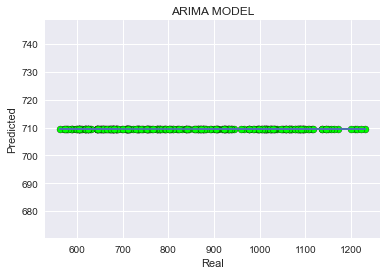

In [47]:
plt.scatter(x_valid.data['Close'].values, pred_010, c='lime', edgecolor='black')
m, b = np.polyfit(x_valid.data['Close'].values, pred_010, 1)
plt.plot(x_valid.data['Close'].values, m*x_valid.data['Close'].values + b)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("ARIMA MODEL")
plt.show() 